# **Delivery Duration Prediction**

## Assignment
When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

Start: the time consumer submits the order (created_at) to
End: when the order will be delivered to the consumer (actual_delivery_time)


## Data Description

The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

 - Columns in historical_data.csv

**Time features**

- market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id

- created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer


**Store features**

- store_id: an id representing the restaurant the order was submitted for
- store_primary_category: cuisine category of the restaurant, e.g., italian, asian
- order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

**Order features**

- total_items: total number of items in the order
- subtotal: total value of the order submitted (in cents)
- num_distinct_items: number of distinct items included in the order
- min_item_price: price of the item with the least cost in the order (in cents)
- max_item_price: price of the item with the highest cost in the order (in cents)

**Market features**

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

- total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
- total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
- total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

**Predictions from other models**

We have predictions from other models for various stages of delivery process that we can use:

- estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
- estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

**Practicalities**
Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance. Explain:

- model(s) used,
- how you evaluated your model performance on the historical data,
- any data processing you performed on the data,
- feature engineering choices you made,
- other information you would like to share your modeling approach.

- We expect the project to take 3-5 hours in total, but feel free to spend as much time as you like on it. Feel free to use any open source packages for the task.


#### To download the dataset <a href="https://drive.google.com/drive/folders/1H4wDwJhfElUd4OfkaoH_VIZhvwDuOMxf?usp=sharing"> Click here </a>

In [1]:
import pandas as pd

# Load the dataset
file_path = 'historical_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset and column information
print(data.head())
print(data.info())

   market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1       

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import numpy as np

In [3]:
# Load the dataset
file_path = 'historical_data.csv'
data = pd.read_csv(file_path)

In [4]:
# Convert timestamp columns to datetime
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

# Calculate the target variable: total_delivery_duration
data['total_delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

# Create additional time-based features
data['created_hour'] = data['created_at'].dt.hour
data['created_dayofweek'] = data['created_at'].dt.dayofweek

# Create more time-related features
data['is_weekend'] = data['created_at'].dt.dayofweek >= 5
data['is_holiday'] = data['created_at'].dt.date.isin(pd.to_datetime(['2015-01-01', '2015-12-25']).date)

# Create interaction features
data['dasher_load'] = data['total_busy_dashers'] / (data['total_onshift_dashers'] + 1)

# Handle missing values for categorical data
data['store_primary_category'].fillna('unknown', inplace=True)
data['order_protocol'].fillna(data['order_protocol'].mode()[0], inplace=True)

# Remove rows with infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# For numerical features, fill missing values with SimpleImputer
numerical_features = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration']
imputer = SimpleImputer(strategy='mean')
data[numerical_features] = imputer.fit_transform(data[numerical_features])

# Drop rows with missing target values
data = data.dropna(subset=['total_delivery_duration'])

In [5]:
# Select features for modeling
features = ['market_id', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 
            'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 
            'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 
            'estimated_store_to_consumer_driving_duration', 'created_hour', 'created_dayofweek', 
            'is_weekend', 'is_holiday', 'dasher_load']
X = data[features]
y = data['total_delivery_duration']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['store_primary_category', 'order_protocol', 'created_hour', 'created_dayofweek'])

# Impute any remaining missing values in the entire feature set
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Ensure there are no values too large for dtype('float64')
X = pd.DataFrame(np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10), columns=X.columns)

# Sample a smaller dataset for cross-validation
sample_size = 5000
data_sample = data.sample(n=sample_size, random_state=42)
X_sample = data_sample[features]
y_sample = data_sample['total_delivery_duration']

# One-hot encode categorical variables for the sample
X_sample = pd.get_dummies(X_sample, columns=['store_primary_category', 'order_protocol', 'created_hour', 'created_dayofweek'])

# Impute any missing values in the sample
X_sample = pd.DataFrame(imputer.fit_transform(X_sample), columns=X_sample.columns)

# Perform 3-fold cross-validation
best_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
cv_scores = cross_val_score(best_model, X_sample, y_sample, cv=3, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
print(f'Cross-Validated MAE (3-fold, 5000-sample): {cv_mae}')

Cross-Validated MAE (3-fold, 5000-sample): 808.4496970793558


In [7]:
from sklearn.metrics import mean_absolute_error
# Train the model with the best parameters on the full dataset
best_model.fit(X, y)

# Predict and evaluate the best model on the full dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f'Mean Absolute Error (Best Model): {mae_best}')

Mean Absolute Error (Best Model): 470.52781932144967


# The above answer is the best model i got

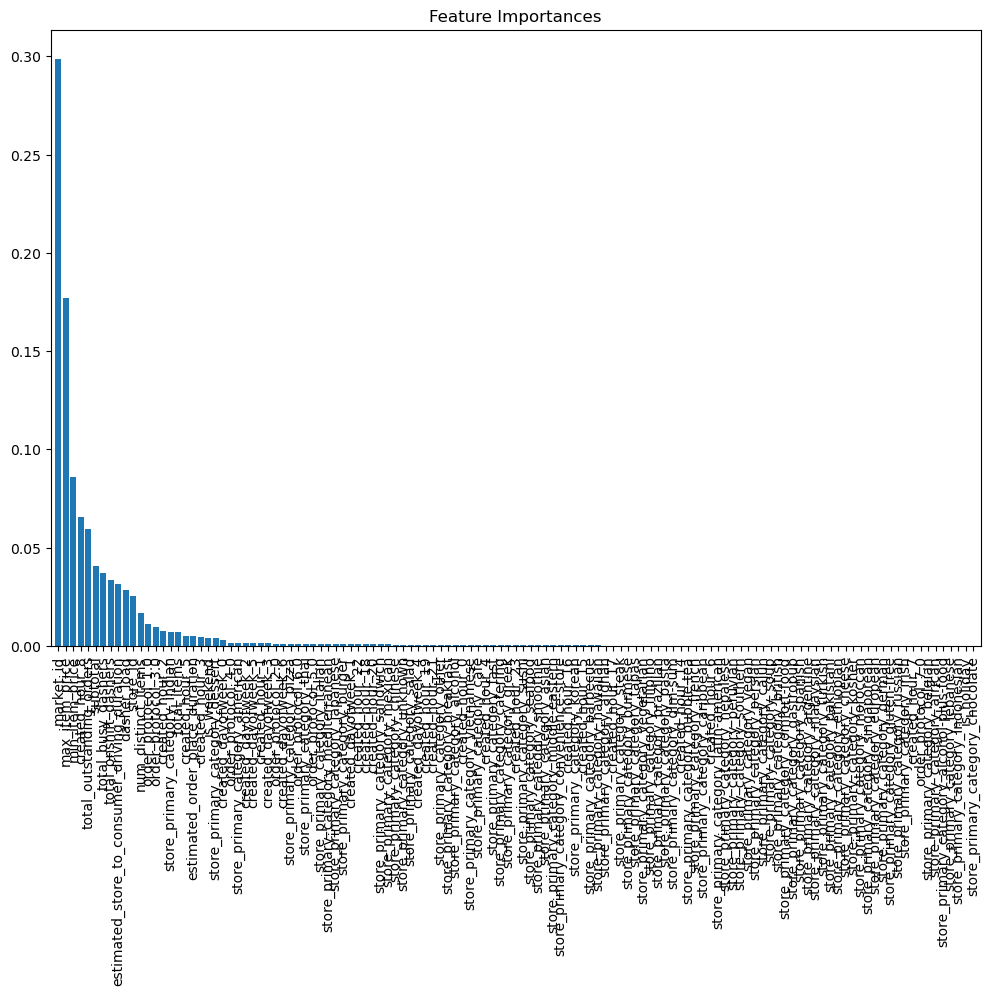

In [8]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


# Just comparing other models

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate the Gradient Boosting model
y_pred_gb = gb_model.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
print(f'Mean Absolute Error (Gradient Boosting): {mae_gb}')


Mean Absolute Error (Gradient Boosting): 903.1053425730075


In [10]:
import xgboost as xgb

# Train an XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'Mean Absolute Error (XGBoost): {mae_xgb}')


Mean Absolute Error (XGBoost): 657.6430735032378


In [13]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.3 MB 393.8 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.3 MB 581.0 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.3 MB 714.4 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.3 MB 794.9 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.3 MB 911.0 kB/s eta 0:00:02
   ------------ --------------------------- 0.4/1.3 MB 1.3 MB/s eta 0:00:01
   --------------- ------------------------ 0.5/1.3 MB 1.3 MB/s eta 0:00:01
   ---------------- ----------------------- 

In [14]:
import lightgbm as lgb

# Train a LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and evaluate the LightGBM model
y_pred_lgb = lgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
print(f'Mean Absolute Error (LightGBM): {mae_lgb}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2394
[LightGBM] [Info] Number of data points in the train set: 157936, number of used features: 109
[LightGBM] [Info] Start training from score 2917.174090
Mean Absolute Error (LightGBM): 800.9136587645419
